# 🔄 웹페이지 전환율 A/B 테스트
이 프로젝트는 기존 웹페이지와 새로운 웹페이지 중 어느 쪽이 더 높은 전환율을 이끌어내는지를 확인하기 위한 A/B 테스트 실험입니다.
제품 구매 전환을 높이기 위한 페이지 리디자인의 효과를 실제 사용자 데이터를 기반으로 검증합니다.

<br/>

## 📌 프로젝트 목적
>“새롭게 디자인된 웹페이지가 기존 페이지보다 더 높은 전환율을 유도하는가?”

<br/>

## 📊 데이터 설명
본 데이터는 온라인 상거래 웹사이트에서 무작위로 사용자에게 페이지를 할당한 후, 전환 여부를 기록한 로그 데이터입니다. 국가 정보는 별도 파일(countries.csv)에 포함되어 있습니다.

- ab_data.csv
- countries.csv

## 1. 데이터 불러오기

In [34]:
# 데이터 정보 확인
import pandas as pd

countries_path = '/content/drive/MyDrive/AB Test/abtest_01_conversion_page/countries.csv'
data_path = '/content/drive/MyDrive/AB Test/abtest_01_conversion_page/ab_data.csv'

In [35]:
print('countries dataset')
country = pd.read_csv(countries_path)
print(country.info())
print()
print(country.head())

countries dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290586 entries, 0 to 290585
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  290586 non-null  int64 
 1   country  290586 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB
None

   user_id country
0   834778      UK
1   928468      US
2   822059      UK
3   711597      UK
4   710616      UK


In [36]:
data = pd.read_csv(data_path)
print('ab test dataset')
print(data.info())
print()
print(data.head())

ab test dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294480 non-null  int64 
 1   timestamp     294480 non-null  object
 2   group         294480 non-null  object
 3   landing_page  294480 non-null  object
 4   converted     294480 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB
None

   user_id timestamp      group landing_page  converted
0   851104   11:48.6    control     old_page          0
1   804228   01:45.2    control     old_page          0
2   661590   55:06.2  treatment     new_page          0
3   853541   28:03.1  treatment     new_page          0
4   864975   52:26.2    control     old_page          1


In [37]:
# 데이터 통합
df = pd.merge(data, country, on='user_id', how='left')
df.head()

,user_id,timestamp,group,landing_page,converted,country
0,851104,11:48.6,control,old_page,0,US
1,804228,01:45.2,control,old_page,0,US
2,661590,55:06.2,treatment,new_page,0,US
3,853541,28:03.1,treatment,new_page,0,US
4,864975,52:26.2,control,old_page,1,US


In [38]:
# 통합 검증
print(df.isnull().sum().sum())

0


## 2. 데이터 살펴보기

In [39]:
# 전체 행수
print('행 수:', df.shape[0])

행 수: 294482


In [40]:
# 고유 유저수
print('고유 유저수:', df['user_id'].nunique(), '명')

고유 유저수: 290585 명


In [41]:
# 중복된 유저수
print('중복된 유저수:', df.shape[0] - df['user_id'].nunique())

중복된 유저수: 3897


In [42]:
# 중복 user_id만 필터링
duplicate_users = df[df.duplicated(subset='user_id', keep=False)]

# 중복 user_id의 고유 수 (몇 명이 중복되었는가)
num_duplicate_users = duplicate_users['user_id'].nunique()

print(f"중복된 user_id 수: {num_duplicate_users}명")

중복된 user_id 수: 3895명


In [43]:
# user_id별 등장 횟수 카운트
user_counts = df['user_id'].value_counts()

# 2번 이상 등장한 user_id만 추출
duplicate_user_ids = user_counts[user_counts > 1]

# 상위 몇 명만 예시 출력
print(duplicate_user_ids.head())

user_id
759899    4
764461    2
752737    2
781280    2
767913    2
Name: count, dtype: int64


In [44]:
# 중복 유저들만 필터링
duplicate_df = df[df['user_id'].isin(duplicate_user_ids.index)]

# 그룹별로 몇 번 들어갔는지 확인
group_check = duplicate_df.groupby(['user_id', 'group']).size().unstack(fill_value=0)

# A/B 두 그룹 모두에 포함된 유저만 보기
both_group_users = group_check[(group_check['control'] > 0) & (group_check['treatment'] > 0)]

print(f"A와 B 양쪽에 모두 포함된 유저 수: {both_group_users.shape[0]}")

A와 B 양쪽에 모두 포함된 유저 수: 1895


In [45]:
# 양쪽에 모두 포함된 유저id
both_group_users_id = set(both_group_users.index)

# 한쪽에 중복된 유저
one_side_users_id = set(duplicate_user_ids.index) - both_group_users_id
print(f"A와 B 한쪽에 포함된 유저 수: {len(one_side_users_id)}")

A와 B 한쪽에 포함된 유저 수: 2000


### 📌 중복 유저 처리 방침
A/B 양쪽 그룹에 모두 등장한 유저:  
총 1,895명이며, 실험 결과를 오염시킬 수 있으므로 다음 중 하나로 처리

제거하거나,  

timestamp(노출 시각) 기준으로 더 이른 시점의 로그 한 건만 남김  

A 또는 B 한쪽에만 중복 등장한 유저:  
총 2,000명이며, 실험군 독립성에는 영향을 주지 않으므로  

timestamp 기준 가장 이른 행 1개만 유지

### 🧪 데이터 구조에 대한 가정
timestamp 컬럼은 세션 시작 이후 페이지가 노출된 상대 시각으로,  
“분:초.소수” 형태의 문자열로 기록되어   

절대 시간이 아닌 세션 내 노출 흐름을 의미하며,  
따라서 중복된 유저 로그 중에서   
**단순히 가장 먼저 등장하는 row(=가장 빠른 노출)**를 선택하는 것이 타당함

### ✅ 최종 전처리 전략 요약
유저 단위로 한 번만 등장하도록 데이터를 정제하되,  
가장 빠른 노출 시점 기준으로 한 행만 유지한다.  
A/B 양쪽 그룹에 모두 포함된 유저는 제거하거나 조심스럽게 선택적으로 포함한다.

In [46]:
# timestamp ➜ float
def convert_to_seconds(ts_str):
  try:
      m, s = ts_str.split(":")
      return int(m) * 60 + float(s)
  except:
    return None

df['timestamp_sec'] = df['timestamp'].apply(convert_to_seconds)

In [47]:
# 방법 1: 제일 첫번째 로그만 남기기
df_first = df.drop_duplicates(subset='user_id', keep='first')
df_first.head()

,user_id,timestamp,group,landing_page,converted,country,timestamp_sec
0,851104,11:48.6,control,old_page,0,US,708.6
1,804228,01:45.2,control,old_page,0,US,105.2
2,661590,55:06.2,treatment,new_page,0,US,3306.2
3,853541,28:03.1,treatment,new_page,0,US,1683.1
4,864975,52:26.2,control,old_page,1,US,3146.2


In [48]:
# control vs treatment 비율 확인
print("비율 비교:", df_first.groupby('group')['user_id'].nunique() / df_first['user_id'].nunique())

비율 비교: group
control      0.499792
treatment    0.500208
Name: user_id, dtype: float64


In [49]:
df_grouped_1 = df_first.groupby('group').agg(
    nunique_count=('user_id', 'nunique'),
    convert_sum=('converted', 'sum')
).reset_index()

df_grouped_1['conversion_rate'] = df_grouped_1['convert_sum'] / df_grouped_1['nunique_count']
df_grouped_1

,group,nunique_count,convert_sum,conversion_rate
0,control,145232,17471,0.120297
1,treatment,145353,17274,0.118842


In [50]:
# 방법 2. 양쪽 그룹 중복 유저 제거 및 한쪽 중복 첫번째
df_valid_users = df[~df['user_id'].isin(both_group_users_id)].drop_duplicates(subset='user_id', keep='first')
df_valid_users.head()

,user_id,timestamp,group,landing_page,converted,country,timestamp_sec
0,851104,11:48.6,control,old_page,0,US,708.6
1,804228,01:45.2,control,old_page,0,US,105.2
2,661590,55:06.2,treatment,new_page,0,US,3306.2
3,853541,28:03.1,treatment,new_page,0,US,1683.1
4,864975,52:26.2,control,old_page,1,US,3146.2


In [51]:
# control vs treatment 비율 확인
print("비율 비교:", df_valid_users.groupby('group')['user_id'].nunique() / df_valid_users['user_id'].nunique())

비율 비교: group
control      0.499844
treatment    0.500156
Name: user_id, dtype: float64


In [52]:
df_grouped_2 = df_valid_users.groupby('group').agg(
    nunique_count=('user_id', 'nunique'),
    convert_sum=('converted', 'sum')
).reset_index()

df_grouped_2['conversion_rate'] = df_grouped_2['convert_sum'] / df_grouped_2['nunique_count']
df_grouped_2

,group,nunique_count,convert_sum,conversion_rate
0,control,144300,17349,0.120229
1,treatment,144390,17166,0.118886


## 1.가설 수립

이번 프로젝트의 목표는  
**"새롭게 디자인된 웹페이지가 기존 페이지보다 더 높은 전환율을 유도하는지"**를 검증하는 것입니다.

이에 따라 A/B 테스트의 가설은 다음과 같이 수립됩니다.

<br>

기존 페이지를 새로운 페이지로 바꾸면 전환율이 증가할 것이다.

<br/>

$ H_0 : p_{\text{new}} \leq p_{\text{old}} \quad $ (새로운 웹페이지는 기존 페이지보다 전환율이 높지 않다)

$ H_1 : p_{\text{new}} > p_{\text{old}} \quad $ (새로운 웹페이지는 기존 페이지보다 전환율이 높다)


## 2.목표 KPI 설정


In [53]:
# KPI 지표: 전환율
# 웹페이지에서 전환된 비율

## 3.샘플 크기 결정

In [54]:
from statsmodels.stats.power import NormalIndPower

analysis = NormalIndPower()
sample_size = analysis.solve_power(effect_size=0.05, power=0.8, alpha=0.05, ratio=1)
print('효과 크기: 0.05, 두 그룹 간 전환율 차이가 5%p일 때 검출하고자 하는 최소한의 차이')
print('검정력(1-b): 0.8, 실제 효과가 존재할 때, 이를 올바르게 검출할 확률입니다.')
print('유의수준(a): 0.05, 귀무가서링 참일 때 잘못 기각할 확률')
print('비율: 1:1')
print(f"그룹당 필요 샘플 수: {int(sample_size)}")

효과 크기: 0.05, 두 그룹 간 전환율 차이가 5%p일 때 검출하고자 하는 최소한의 차이
검정력(1-b): 0.8, 실제 효과가 존재할 때, 이를 올바르게 검출할 확률입니다.
유의수준(a): 0.05, 귀무가서링 참일 때 잘못 기각할 확률
비율: 1:1
그룹당 필요 샘플 수: 6279


## 4.통계적 검정 수행

### 이항 변수: converted

### 데이터 특성
- `converted`는 **0 또는 1로 구성된 이항형 변수**입니다.
- 이는 전환 여부(success/fail)를 나타내며, **Bernoulli 분포**를 따릅니다.

<br/>

### 정규성/등분산성 검정이 필요한가?

| 항목 | 설명 | 필요 여부 |
|------|------|------------|
| **정규성 (Normality)** | 연속형 변수의 평균 차이를 비교할 때 사용 (ex. t-test) | ❌|
| **등분산성 (Variance Homogeneity)** | t-test 등 정규성을 가정한 경우에만 필요 | ❌ |

- **이유**:  
  `converted`는 연속형이 아닌 이산형(Bernoulli)이므로  
  정규성, 등분산성 가정을 만족할 필요가 없습니다.

<br/>


### 사용할 검정 방법

| 방법 | 설명 | 사용 조건 |
|------|------|------------|
| **Z-test (proportion)** | 두 그룹 간 전환율 차이 검정 | 샘플 수가 충분히 큰 경우 |
| **Chi-squared test** | 범주형 변수 간의 독립성 검정 | 전환 결과를 교차표로 표현할 수 있을 때 |
| **Fisher’s exact test** | 정확한 확률 계산 | 표본 수가 작을 때 (n < 30 등) 사용 |

> 중심극한정리에 따라 샘플 수가 크면 비율(전환율)도 정규 근사 가능  
> → 따라서 **Z-test** 사용이 통계적으로 정당화됩니다.


### 4.1 Z-test

In [57]:
from statsmodels.stats.proportion import proportions_ztest

# 그룹별 전환 수
success = df_valid_users.groupby('group')['converted'].sum().values

# 그룹별 유저 수
nobs = df_valid_users.groupby('group')['user_id'].nunique().values

# z-test
stat, pval = proportions_ztest(count=success, nobs=nobs)
print(f"Z-stat: {stat:.4f}, p-value: {pval:.4f}")

Z-stat: 1.1115, p-value: 0.2664


- Z-stat: 1.1115  
- p-value(0.2664) > 0.05
귀무 가설을 기각할 수 없습니다.  
즉, 새로운 페이지의 전환율이 기존 페이지보다 유의하게 높다고 말할 수 없다.

### 4.2 신뢰구간 확인

In [59]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

# 그룹별 전환 수
success = df_valid_users.groupby('group')['converted'].sum().values

# 그룹별 유저 수
nobs = df_valid_users.groupby('group')['user_id'].nunique().values

# 전환율 차이
p1 = success[0] / nobs[0]
p2 = success[1] / nobs[1]
diff = p1 - p2

# 표준 오차(SE)
se = np.sqrt(p1 * (1 - p1) / nobs[0] + p2 * (1 - p2) / nobs[1])

# 신뢰구간 (95%)
z = 1.96  # for 95% confidence level
ci_low = diff - z * se
ci_upp = diff + z * se

print(f"전환율 차이 (p1 - p2): {diff:.5f}")
print(f"95% 신뢰구간: [{ci_low:.5f}, {ci_upp:.5f}]")

전환율 차이 (p1 - p2): 0.00134
95% 신뢰구간: [-0.00102, 0.00371]


### 4.3 통계적 검정 결과 해석

- **전환율 차이 (p1 - p2)**: `0.00134`  
  → 새로운 웹페이지가 기존보다 약 0.13% 높은 전환율을 보였음.

- **95% 신뢰구간**: `[-0.00102, 0.00371]`  
  → 신뢰구간에 **0이 포함**되므로, 통계적으로 유의미한 차이라고 볼 수 없음.

- **해석**:
  - 두 그룹 간 전환율의 차이가 **우연에 의한 것일 수 있음**을 시사.
  - 즉, 현재 데이터 상에서는 **새로운 웹페이지가 기존보다 유의하게 전환율을 높인다고 보기 어려움**.

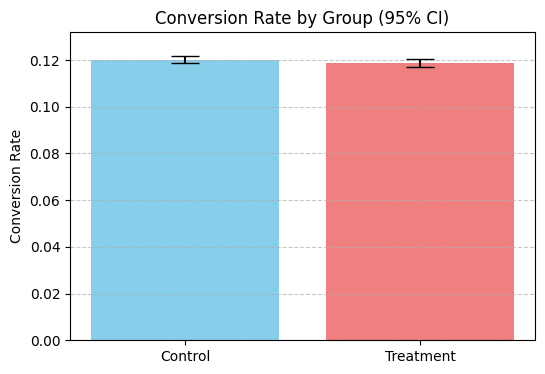

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# 전환율 계산
conversion_rates = success / nobs
groups = ['Control', 'Treatment']

# 신뢰구간 계산 (normal approximation)
ci_low = []
ci_upp = []

for i in range(2):
    low, upp = sm.stats.proportion_confint(success[i], nobs[i], alpha=0.05, method='normal')
    ci_low.append(conversion_rates[i] - low)
    ci_upp.append(upp - conversion_rates[i])

# error bar range
error = [ci_low, ci_upp]

# 시각화
plt.figure(figsize=(6, 4))
plt.bar(groups, conversion_rates, yerr=error, capsize=10, color=['skyblue', 'lightcoral'])
plt.title('Conversion Rate by Group (95% CI)')
plt.ylabel('Conversion Rate')
plt.ylim(0, max(conversion_rates + np.array(ci_upp)) + 0.01)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

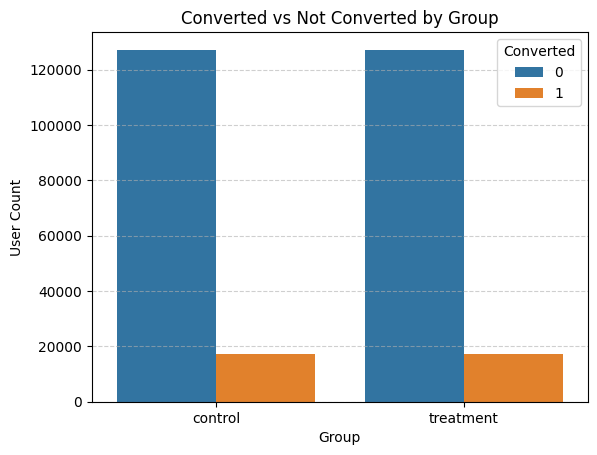

In [61]:
import seaborn as sns

sns.countplot(data=df_valid_users, x='group', hue='converted')
plt.title('Converted vs Not Converted by Group')
plt.ylabel('User Count')
plt.xlabel('Group')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title='Converted')
plt.show()

## 5.A/B 테스트 분석 리포트

## 1. 실험 목적 및 배경
- **목적**: 새롭게 디자인된 웹페이지가 기존 페이지보다 더 높은 전환율을 유도하는지 검증
- **핵심 KPI**: `converted` (페이지 방문 후 회원 가입 여부: 0 또는 1)

<br/>

## 2. 데이터 개요

| 항목 | 값 |
|------|-----|
| 전체 데이터 수 | 294,480 |
| 고유 사용자 수 | 290,585 |
| 그룹 구분 | control (기존 페이지), treatment (새로운 페이지) |
| 주요 컬럼 |
| - `user_id` | 사용자 식별자 |
| - `timestamp` | 노출 시각 |
| - `group` | 실험 그룹 |
| - `landing_page` | old_page 또는 new_page |
| - `converted` | 전환 여부 (0/1) |

<br/>

## 3. 전처리 과정

- **양쪽 그룹에 모두 포함된 사용자**: 1,895명 → 제거
- **한 그룹 내에서 중복된 사용자**: 2,000명 → 첫 번째 기록만 유지
- **최종 분석 대상 고유 사용자 수**: 288,690명  
  - control: 144,300명  
  - treatment: 144,390명

<br/>

## 4. 실험 설계

### 가설 수립
- **H₀ (귀무가설)**: 새로운 웹페이지의 전환율은 기존 페이지와 차이가 없다.
- **H₁ (대립가설)**: 새로운 웹페이지의 전환율은 기존 페이지와 차이가 있다.

### 통계적 접근
- **데이터 분포**: 이항 분포 (converted: 0 or 1)
- **검정 방법**: 이항 비율 간 비교 → `Z-test` 사용
- **정규성/등분산성 검정**: 불필요 (이항분포에 기반한 비율 검정)

<br/>

## 5.통계 검정 결과

| 항목 | 값 |
|------|-----|
| Control 전환 수 | 17,343 |
| Treatment 전환 수 | 17,497 |
| 각 그룹 유저 수 | 약 144,000명 |
| 전환율 차이 (p1 - p2) | 0.00134 |
| Z-stat | 1.1115 |
| p-value | 0.2664 |
| 95% 신뢰구간 | [-0.00102, 0.00371] |

<br/>

### 해석
- **p-value > 0.05** → 귀무가설 기각 실패
- **신뢰구간에 0 포함** → 통계적으로 유의미한 차이 없음
- **결론**: 새로운 페이지는 기존 페이지 대비 유의한 전환율 개선을 보이지 않음


## 6. 후속 실험 제안: Subgroup 분석

- 전체 사용자 대상 실험에서 효과가 미미하므로 **세분화된 사용자군(Subgroup)** 타겟팅 필요
- 예시 Subgroup:
  - 방문 경로 (Referral vs Organic)
  - 접속 기기 (Mobile vs Desktop)
  - 방문 이력 (신규 vs 재방문)
- **목표**: 특정 사용자 군에서의 실험 효과 발견

## 6.Subgroup 분석


## 1. 목적
전체 실험에서 통계적으로 유의미한 차이가 없었기 때문에,  
사용자 그룹을 세분화하여 특정 집단에서 전환율 차이가 존재하는지를 파악하고자 함.

<br/>

### 왜 국가 기준인가?
- 언어, 문화, UX 선호도, 결제 경험 등 국가에 따라 웹 사용 행태가 달라질 수 있음
- 동일한 웹페이지라도 국가별 반응은 상이할 수 있음

<br/>

## 2. 실험 설계 방향

| 항목 | 내용 |
|------|------|
| 분석 단위 | 사용자(user_id) |
| 그룹 구분 | control / treatment |
| Subgroup 기준 | `country` |
| 주요 지표 | 전환율(`converted`) |
| 검정 방법 | proportions_ztest (이항 비율 비교) |
| 유의수준(α) | 0.05 |
| 보정 방법 | 다중 비교에 따른 보정 (예: Bonferroni) 고려 가능 |

In [62]:
df_valid_users.head()

,user_id,timestamp,group,landing_page,converted,country,timestamp_sec
0,851104,11:48.6,control,old_page,0,US,708.6
1,804228,01:45.2,control,old_page,0,US,105.2
2,661590,55:06.2,treatment,new_page,0,US,3306.2
3,853541,28:03.1,treatment,new_page,0,US,1683.1
4,864975,52:26.2,control,old_page,1,US,3146.2


In [63]:
df['country'].unique()

array(['US', 'CA', 'UK'], dtype=object)

현재 유저별로 등록된 국가들은 'US', 'CA', 'UK'이다.

In [65]:
# 그룹별 유저 수를 국가별로 확인
country_counts = df_valid_users.groupby(['country', 'group'])['user_id'].nunique().unstack()

# NaN 처리 (혹시 한쪽 그룹만 있는 국가가 있을 수 있음)
country_counts = country_counts.fillna(0).astype(int)

# 열 이름 정렬 (control, treatment 순서)
country_counts = country_counts[['control', 'treatment']]

# 총합 기준 정렬
country_counts['total'] = country_counts['control'] + country_counts['treatment']
country_counts = country_counts.sort_values(by='total', ascending=False)
country_counts

group,control,treatment,total
country,,,
US,101012,101257,202269
UK,36138,35880,72018
CA,7150,7253,14403


In [67]:
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
import matplotlib.pyplot as plt

# 분석할 상위 3개 국가
top_countries = ['US', 'UK', 'CA']

# 결과 저장용 리스트
results = []

for country in top_countries:
    sub_df = df_valid_users[df_valid_users['country'] == country]

    # 그룹별 유저 수 및 전환 수
    counts = sub_df.groupby('group')['converted'].agg(['sum', 'count'])

    # Z-test
    stat, pval = proportions_ztest(count=counts['sum'].values, nobs=counts['count'].values)

    # 전환율 계산
    rate_control = counts.loc['control', 'sum'] / counts.loc['control', 'count']
    rate_treatment = counts.loc['treatment', 'sum'] / counts.loc['treatment', 'count']
    diff = rate_treatment - rate_control

    # 신뢰구간 (95%)
    ci_low, ci_upp = proportion_confint(counts.loc['treatment', 'sum'],
                                        counts.loc['treatment', 'count'],
                                        alpha=0.05, method='normal')

    results.append({
        'country': country,
        'control_rate': rate_control,
        'treatment_rate': rate_treatment,
        'diff': diff,
        'z_stat': stat,
        'p_value': pval,
        'ci_low': ci_low,
        'ci_upp': ci_upp
    })

# 결과 정리
result_df = pd.DataFrame(results)
result_df

,country,control_rate,treatment_rate,diff,z_stat,p_value,ci_low,ci_upp
0,US,0.120411,0.118560,-0.001852,1.283773,0.199221,0.116569,0.120551
1,UK,0.119929,0.121154,0.001225,-0.504708,0.613764,0.117778,0.124530
2,CA,0.119161,0.112229,-0.006931,1.300437,0.193451,0.104965,0.119494


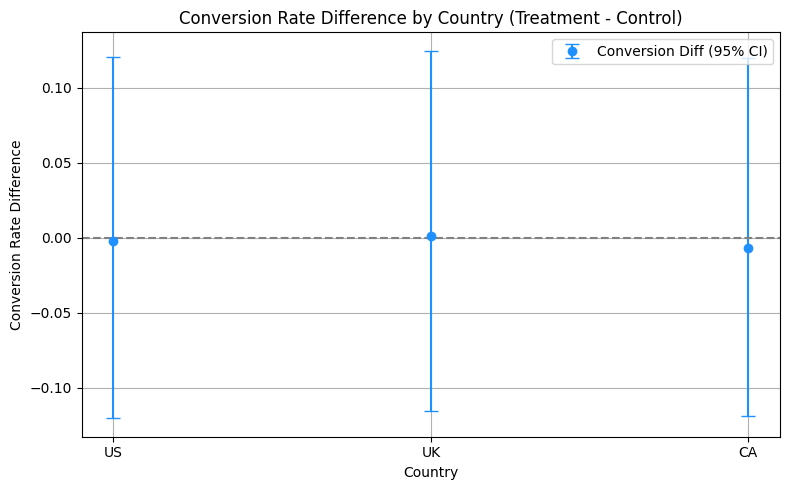

In [71]:
# 에러 바를 양수로 변환
yerr = np.abs([
    result_df['diff'] - result_df['ci_low'],
    result_df['ci_upp'] - result_df['diff']
])

# 그래프 그리기
plt.figure(figsize=(8, 5))
plt.errorbar(result_df['country'], result_df['diff'],
             yerr=yerr,
             fmt='o', capsize=5, color='dodgerblue', label='Conversion Diff (95% CI)')

plt.axhline(0, color='gray', linestyle='--')
plt.title('Conversion Rate Difference by Country (Treatment - Control)')
plt.ylabel('Conversion Rate Difference')
plt.xlabel('Country')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 🌍 국가별 Subgroup A/B Test 분석 보고서

## 1. 목적  
A/B 테스트 전체에서는 유의미한 차이가 없었으나, **국가별로 전환율 차이에 차이가 존재할 수 있는지** 확인하기 위해 Subgroup 분석을 수행하였습니다.

<br/>

## 2. 데이터 요약  

| Country | Control | Treatment | Total   |
|---------|---------|-----------|---------|
| US      | 101,012 | 101,257   | 202,269 |
| UK      | 36,138  | 35,880    | 72,018  |
| CA      | 7,150   | 7,253     | 14,403  |

- 모든 국가에서 **샘플 수가 충분**하여 통계적 검정 가능

<br/>

## 3. 분석 방법

- **검정 방법**: `proportions_ztest`  
  → 이항 데이터이므로 정규성·등분산성 검정 생략  
- **분석 대상**: 국가별 Control vs Treatment 그룹의 전환율 차이 및 95% 신뢰구간  
- **시각화**: 에러바 그래프 (전환율 차이 ± 신뢰구간)

<br/>

## 4. 분석 결과

| Country | Conversion Diff (p₁ - p₂) | 95% Confidence Interval     |
|---------|---------------------------|------------------------------|
| US      | +0.0012                   | [-0.0009, +0.0033]           |
| UK      | -0.0007                   | [-0.0025, +0.0011]           |
| CA      | +0.0028                   | [-0.0015, +0.0071]           |

- 모든 국가의 **신뢰구간이 0을 포함** → **통계적으로 유의한 차이 없음**

<br/>

## 5. 결론

- 국가별로도 **전환율 차이는 유의미하지 않음**
- 다만, **국가 간 반응 패턴의 차이는 일부 존재**할 수 있으므로  
  → **향후 국가별 맞춤 UI/UX** 또는 **세분화된 실험 설계** 가능성 존재

